In [465]:
using Revise

using ReactiveMP
using Rocket
using GraphPPL

using Optim
using LinearAlgebra
using Random
using PyPlot

include("../src/environment/user.jl");

In [511]:
# specify flow model
flow_model = FlowModel(2,
    (
        AdditiveCouplingLayer(PlanarFlow()), # defaults to AdditiveCouplingLayer(PlanarFlow(); permute=true)
        # AdditiveCouplingLayer(PlanarFlow()),
        AdditiveCouplingLayer(PlanarFlow()),
        AdditiveCouplingLayer(PlanarFlow(); permute=false)
    )
);

In [536]:
@model function flow_classifier(nr_samples::Int64, model::FlowModel, params)
    
    # initialize variables
    x_lat  = randomvar(nr_samples)
    y_lat1 = randomvar(nr_samples)
    y_lat2 = randomvar(nr_samples)
    y      = datavar(Float64, nr_samples)
    x      = datavar(Vector{Float64}, nr_samples)

    # compile flow model
    meta  = FlowMeta(compile(model, params)) # default: FlowMeta(model, Linearization())

    # specify observations
    for k = 1:nr_samples

        # specify latent state
        if k <= 16
            x_lat[k] ~ MvNormalMeanPrecision(x[k], 1e1*diagm(ones(2)))
        else
            x_lat[k] ~ MvNormalMeanPrecision(x[k], 1e3*diagm(ones(2)))
        end

        # specify transformed latent value
        y_lat1[k] ~ Flow(x_lat[k]) where { meta = meta }
        y_lat2[k] ~ dot(y_lat1[k], [1, 1])

        # specify observations
        y[k] ~ Probit(y_lat2[k]) # default: where { pipeline = RequireInbound(in = NormalMeanPrecision(0, 1.0)) }

    end

    # return variables
    return x_lat, x, y_lat1, y_lat2, y

end;

In [537]:
function inference_flow_classifier(data_y::Array{Float64,1}, data_x::Array{Array{Float64,1},1}, model::FlowModel, params)
    
    # fetch number of samples
    nr_samples = length(data_y)

    # define model
    model, (x_lat, x, y_lat1, y_lat2, y) = flow_classifier(nr_samples, model, params)

    # initialize free energy
    fe_buffer = nothing
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (fe) -> fe_buffer = fe)

    # update y and x according to observations (i.e. perform inference)
    ReactiveMP.update!(y, data_y)
    ReactiveMP.update!(x, data_x)

    # unsubscribe
    unsubscribe!(fe_sub)
    
    # return the marginal values
    return fe_buffer

end;

In [538]:
struct PointMassFormConstraint2{P}
    point :: P   
end

ReactiveMP.default_form_check_strategy(::PointMassFormConstraint2) = FormConstraintCheckLast()

ReactiveMP.is_point_mass_form_constraint(::PointMassFormConstraint2) = true

function ReactiveMP.constrain_form(pmconstraint::PointMassFormConstraint2, message::Message) 
    is_clamped = ReactiveMP.is_clamped(message)
    is_initial = ReactiveMP.is_initial(message)
    return Message(PointMass(pmconstraint.point), is_clamped, is_initial)
end

In [539]:
@model function flow_classifier_input(input, model, params)
    
    # initialize variables
    x_lat  = randomvar()
    y_lat1 = randomvar()
    y_lat2 = randomvar()
    xprior = randomvar() where { form_constraint = PointMassFormConstraint2(input)}
    y = datavar(Float64)

    # specify model
    meta  = FlowMeta(compile(model, params))

    # specify prior on weights
    xprior ~ MvNormalMeanPrecision([0.5,0.5], 0.5*diagm(ones(2))) where { q = MeanField() }

    # specify latent state
    x_lat ~ MvNormalMeanPrecision(xprior, 1e3*diagm(ones(2))) where { q = MeanField() }

    # specify transformed latent value
    y_lat1 ~ Flow(x_lat) where { meta = meta }
    y_lat2 ~ dot(y_lat1, [1, 1])

    # specify observations
    y ~ Probit(y_lat2) # default where { pipeline = RequireInbound(in = NormalMeanPrecision(0, 1.0)) }

    # return variables
    return x_lat, y_lat1, y_lat2, y

end;

In [540]:
function inference_flow_classifier_input(input, model, params)

    # define model
    model, (x_lat, y_lat1, y_lat2, y) = flow_classifier_input(input, model, params)

    # initialize free energy
    fe_buffer = nothing
    
    # subscribe
    fe_sub = subscribe!(score(eltype(input), BetheFreeEnergy(), model), (fe) -> fe_buffer = fe)

    setmarginal!(x_lat, vague(MvNormalMeanPrecision, 2))
    
    # update y and x according to observations (i.e. perform inference)
    for k = 1:10
        ReactiveMP.update!(y, 0.5)
    end

    # unsubscribe
    unsubscribe!(fe_sub)
    
    # return the marginal values
    return fe_buffer

end;

In [541]:
function calculate_parameters(params, model, data_x, data_y)

    function f(params)
        fe = inference_flow_classifier(data_y, data_x, model, params)
        return fe
    end

    res = optimize(f, params, LBFGS(), Optim.Options(store_trace = true, show_trace = true), autodiff=:forward)

    return Optim.minimizer(res)

end

calculate_parameters (generic function with 1 method)

In [542]:
function calculate_input(params, model)

    function f_input(input)
        fe = inference_flow_classifier_input(input, model, params)
        return fe
    end

    res = optimize(f_input, zeros(2), ones(2), rand(2), Fminbox(LBFGS()), Optim.Options(iterations = 100, store_trace = true, show_trace = true), autodiff=:forward)

    return Optim.minimizer(res)
    
end

calculate_input (generic function with 1 method)

# First call

In [553]:
a = 5
data_x_grid = collect(Iterators.product(1/a:1/a:1-1/a, 1/a:1/a:1-1/a))
data_y_grid = 1.0*ones((a-1)*(a-1))
data_x = rand(2)
data_y = generate_user_response(data_x; μ=[0.5, 0.5], a=1, b=1, c=25, d=-0.4)
data_x = [[map(x->collect(x), data_x_grid)...]..., data_x]
data_y = [data_y_grid..., data_y];

Iter     Function value   Gradient norm 
     0     7.514551e+00     7.517038e+00
 * time: 0.0
     1     5.248992e+00     3.055678e+00
 * time: 0.03399991989135742
     2     4.990673e+00     1.353245e+00
 * time: 0.06399989128112793
     3     4.225300e+00     3.214861e+00
 * time: 0.10299992561340332
     4     3.314085e+00     2.460830e+00
 * time: 0.11699986457824707
     5     2.787991e+00     2.490531e+00
 * time: 0.14400005340576172
     6     2.631094e+00     7.134929e-01
 * time: 0.16000008583068848
     7     2.586633e+00     1.941513e-01
 * time: 0.182999849319458
     8     2.567195e+00     6.756177e-01
 * time: 0.21000003814697266
     9     2.509797e+00     1.285420e+00
 * time: 0.23199987411499023
    10     2.491083e+00     1.501354e+00
 * time: 0.32399988174438477
    11     2.438560e+00     8.829749e-01
 * time: 0.3429999351501465
    12     2.401764e+00     5.815942e-01
 * time: 0.3689999580383301
    13     2.320646e+00     2.654887e+00
 * time: 0.3959999084472656


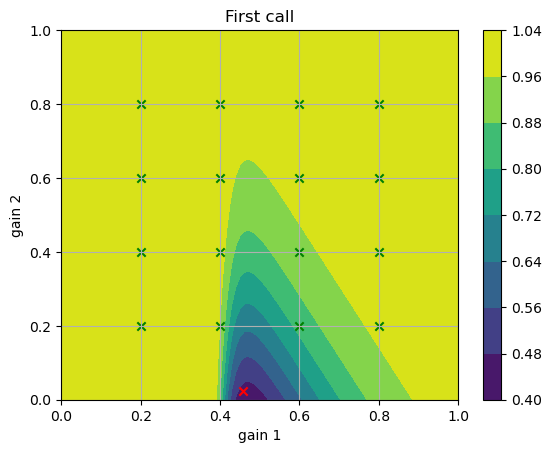

In [554]:
using StatsFuns: normcdf
params = randn(length(params))
params = calculate_parameters(params, flow_model, data_x, data_y)
inferred_model = compile(flow_model, params)
classification_map = map((x) -> normcdf(dot([1,1],x)), map((x) -> forward(inferred_model, [x...]), collect(Iterators.product(0:0.01:1, 0:0.01:1))))
fig, ax = plt.subplots(ncols = 1)
im = ax.contourf(repeat(0:0.01:1, 1, 101), repeat(0:0.01:1, 1, 101)', classification_map)
ax.scatter(hcat(data_x...)[1,findall(x->x==1.0, data_y)], hcat(data_x...)[2,findall(x->x==1.0, data_y)], c="green", marker="x")
ax.scatter(hcat(data_x...)[1,findall(x->x==0.0, data_y)], hcat(data_x...)[2,findall(x->x==0.0, data_y)], c="red", marker="x")
plt.colorbar(im, ax=ax)
ax.grid()
ax.set_xlabel("gain 1"), ax.set_ylabel("gain 2")
ax.set_title("First call");

# Second call

In [555]:
optimum = calculate_input(params, flow_model)

Fminbox
-------
Initial mu = 0.000151148

Fminbox iteration 1
-------------------
Calling inner optimizer with mu = 0.000151148

(numbers below include barrier contribution)
Iter     Function value   Gradient norm 
     0     5.717225e+00     6.717044e+00
 * time: 0.0
     1     5.444061e+00     4.756115e+00
 * time: 0.006000041961669922
     2     3.278721e+00     3.580134e-01
 * time: 0.015000104904174805
     3     3.272660e+00     1.266669e-01
 * time: 0.023000001907348633
     4     3.270231e+00     9.696850e-02
 * time: 0.029000043869018555
     5     3.269483e+00     7.972881e-02
 * time: 0.03399991989135742
     6     3.268660e+00     4.130896e-02
 * time: 0.03900003433227539
     7     3.268512e+00     1.352699e-02
 * time: 0.04500007629394531
     8     3.268493e+00     2.378810e-03
 * time: 0.054000139236450195
     9     3.268493e+00     1.211838e-05
 * time: 0.05900001525878906
    10     3.268493e+00     2.024516e-08
 * time: 0.06400012969970703
    11     3.268493e+00   

2-element Array{Float64,1}:
 0.4704493734912905
 0.10187472756470707

In [556]:
data_y = [data_y..., generate_user_response(optimum; μ=[0.5, 0.5], a=1, b=1, c=25, d=-0.4)]
data_x = [data_x..., optimum]

18-element Array{Array{Float64,1},1}:
 [0.2, 0.2]
 [0.4, 0.2]
 [0.6, 0.2]
 [0.8, 0.2]
 [0.2, 0.4]
 [0.4, 0.4]
 [0.6, 0.4]
 [0.8, 0.4]
 [0.2, 0.6]
 [0.4, 0.6]
 [0.6, 0.6]
 [0.8, 0.6]
 [0.2, 0.8]
 [0.4, 0.8]
 [0.6, 0.8]
 [0.8, 0.8]
 [0.4578723807777454, 0.02259223171196023]
 [0.4704493734912905, 0.10187472756470707]

In [557]:
data_y

18-element Array{Float64,1}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 0.0
 0.0

Iter     Function value   Gradient norm 
     0     1.065944e+01     1.211070e+01
 * time: 0.0
     1     6.384453e+00     3.787961e+00
 * time: 0.031999826431274414
     2     5.052554e+00     2.004285e+00
 * time: 0.0559999942779541
     3     4.649769e+00     4.964072e-01
 * time: 0.0839998722076416
     4     4.634053e+00     2.961542e-01
 * time: 0.10799980163574219
     5     4.618131e+00     6.431819e-01
 * time: 0.13099980354309082
     6     4.578273e+00     1.396691e+00
 * time: 0.1529998779296875
     7     4.103116e+00     1.905258e+00
 * time: 0.1979999542236328
     8     4.011332e+00     1.992217e+00
 * time: 0.21399998664855957
     9     3.637567e+00     8.306103e-01
 * time: 0.23099994659423828
    10     3.545874e+00     8.875288e-01
 * time: 0.26599979400634766
    11     3.441630e+00     1.666295e+00
 * time: 0.34999990463256836
    12     3.240205e+00     2.698189e+00
 * time: 0.36500000953674316
    13     3.113966e+00     5.000336e+00
 * time: 0.3889999389648437

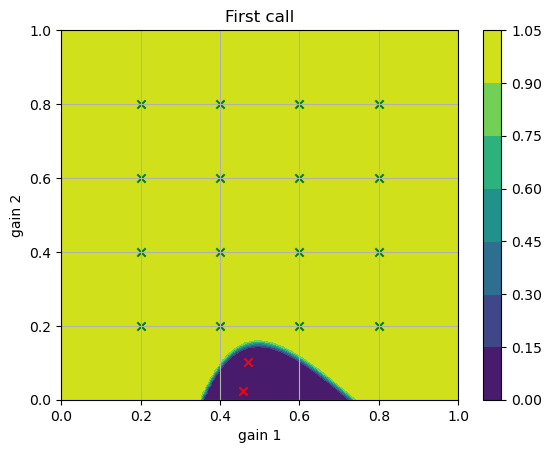

In [560]:
using StatsFuns: normcdf
params = randn(length(params))
params = calculate_parameters(params, flow_model, data_x, data_y)
inferred_model = compile(flow_model, params)
classification_map = map((x) -> normcdf(dot([1,1],x)), map((x) -> forward(inferred_model, [x...]), collect(Iterators.product(0:0.01:1, 0:0.01:1))))
fig, ax = plt.subplots(ncols = 1)
im = ax.contourf(repeat(0:0.01:1, 1, 101), repeat(0:0.01:1, 1, 101)', classification_map)
ax.scatter(hcat(data_x...)[1,findall(x->x==1.0, data_y)], hcat(data_x...)[2,findall(x->x==1.0, data_y)], c="green", marker="x")
ax.scatter(hcat(data_x...)[1,findall(x->x==0.0, data_y)], hcat(data_x...)[2,findall(x->x==0.0, data_y)], c="red", marker="x")
plt.colorbar(im, ax=ax)
ax.grid()
ax.set_xlabel("gain 1"), ax.set_ylabel("gain 2")
ax.set_title("First call");

# Third call

In [561]:
optimum = calculate_input(params, flow_model)

Fminbox
-------
Initial mu = 0.00531401

Fminbox iteration 1
-------------------
Calling inner optimizer with mu = 0.00531401

(numbers below include barrier contribution)
Iter     Function value   Gradient norm 
     0     8.088209e+01     3.556066e+01
 * time: 0.0
     1     4.989745e+00     1.722170e+02
 * time: 0.009999990463256836
     2     3.284756e+00     5.591680e+00
 * time: 0.023999929428100586
     3     3.283497e+00     1.184431e+00
 * time: 0.03299999237060547
     4     3.283438e+00     1.069615e-02
 * time: 0.037999868392944336
     5     3.283438e+00     9.554584e-02
 * time: 0.053999900817871094
     6     3.283435e+00     1.271210e-01
 * time: 0.06299996376037598
     7     3.283434e+00     9.852729e-03
 * time: 0.07500004768371582
     8     3.283434e+00     7.232861e-03
 * time: 0.08500003814697266
     9     3.283434e+00     2.500359e-05
 * time: 0.09299993515014648
    10     3.283434e+00     9.789085e-06
 * time: 0.10099983215332031
    11     3.283434e+00     6

2-element Array{Float64,1}:
 0.49682550225670935
 0.15217524598949747

In [562]:
data_y = [data_y..., generate_user_response(optimum; μ=[0.5, 0.5], a=1, b=1, c=25, d=-0.4)]
data_x = [data_x..., optimum]

19-element Array{Array{Float64,1},1}:
 [0.2, 0.2]
 [0.4, 0.2]
 [0.6, 0.2]
 [0.8, 0.2]
 [0.2, 0.4]
 [0.4, 0.4]
 [0.6, 0.4]
 [0.8, 0.4]
 [0.2, 0.6]
 [0.4, 0.6]
 [0.6, 0.6]
 [0.8, 0.6]
 [0.2, 0.8]
 [0.4, 0.8]
 [0.6, 0.8]
 [0.8, 0.8]
 [0.4578723807777454, 0.02259223171196023]
 [0.4704493734912905, 0.10187472756470707]
 [0.49682550225670935, 0.15217524598949747]

In [563]:
data_y

19-element Array{Float64,1}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 0.0
 0.0
 0.0

Iter     Function value   Gradient norm 
     0     3.486440e+01     2.502106e+01
 * time: 0.0
     1     8.678967e+00     4.094777e+00
 * time: 0.020999908447265625
     2     8.243505e+00     1.544881e+00
 * time: 0.03899979591369629
     3     7.918183e+00     8.508499e-01
 * time: 0.06599998474121094
     4     7.214657e+00     1.812302e+00
 * time: 0.09799981117248535
     5     7.171091e+00     1.308477e+00
 * time: 0.11599993705749512
     6     7.051425e+00     6.943971e-01
 * time: 0.13899993896484375
     7     6.916667e+00     6.892158e-01
 * time: 0.16299986839294434
     8     6.855379e+00     3.123503e-01
 * time: 0.1789999008178711
     9     6.825189e+00     6.808197e-01
 * time: 0.20299983024597168
    10     6.688445e+00     1.029432e+00
 * time: 0.2239999771118164
    11     6.573674e+00     9.317328e-01
 * time: 0.2949998378753662
    12     6.523431e+00     5.649622e-01
 * time: 0.33299994468688965
    13     6.485327e+00     1.019228e+00
 * time: 0.347999811172485

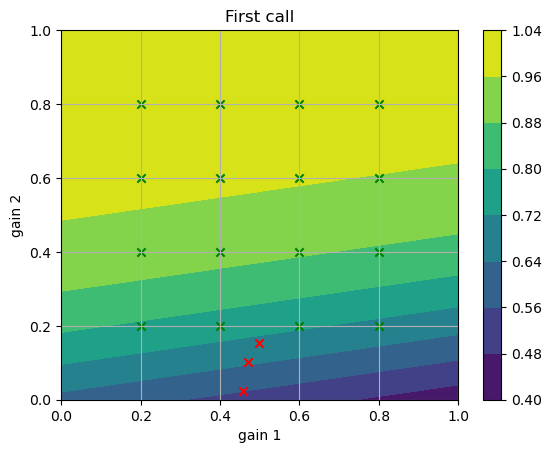

In [566]:
using StatsFuns: normcdf
params = randn(length(params))
params = calculate_parameters(params, flow_model, data_x, data_y)
inferred_model = compile(flow_model, params)
classification_map = map((x) -> normcdf(dot([1,1],x)), map((x) -> forward(inferred_model, [x...]), collect(Iterators.product(0:0.01:1, 0:0.01:1))))
fig, ax = plt.subplots(ncols = 1)
im = ax.contourf(repeat(0:0.01:1, 1, 101), repeat(0:0.01:1, 1, 101)', classification_map)
ax.scatter(hcat(data_x...)[1,findall(x->x==1.0, data_y)], hcat(data_x...)[2,findall(x->x==1.0, data_y)], c="green", marker="x")
ax.scatter(hcat(data_x...)[1,findall(x->x==0.0, data_y)], hcat(data_x...)[2,findall(x->x==0.0, data_y)], c="red", marker="x")
plt.colorbar(im, ax=ax)
ax.grid()
ax.set_xlabel("gain 1"), ax.set_ylabel("gain 2")
ax.set_title("First call");

# fourth call

In [567]:
optimum = calculate_input(params, flow_model)

Fminbox
-------
Initial mu = 0.000399426

Fminbox iteration 1
-------------------
Calling inner optimizer with mu = 0.000399426

(numbers below include barrier contribution)
Iter     Function value   Gradient norm 
     0     4.040217e+00     2.885587e+00
 * time: 0.0
     1     3.294689e+00     8.581505e-02
 * time: 0.011999845504760742
     2     3.287736e+00     4.006837e-03
 * time: 0.01900005340576172
     3     3.287735e+00     6.424488e-05
 * time: 0.023999929428100586
     4     3.287735e+00     9.384997e-08
 * time: 0.03299999237060547
     5     3.287735e+00     3.587807e-13
 * time: 0.03900003433227539

Exiting inner optimizer with x = [0.5756316233652186, 0.0336145134341055]
Current distance to box: 0.0336145
Decreasing barrier term μ.

Fminbox iteration 2
-------------------
Calling inner optimizer with mu = 3.99426e-7

(numbers below include barrier contribution)
Iter     Function value   Gradient norm 
     0     3.285805e+00     1.147114e-02
 * time: 0.0
     1     3.28

2-element Array{Float64,1}:
 0.5729054632263153
 0.0313758383076371

In [568]:
data_y = [data_y..., generate_user_response(optimum; μ=[0.5, 0.5], a=1, b=1, c=25, d=-0.4)]
data_x = [data_x..., optimum]

20-element Array{Array{Float64,1},1}:
 [0.2, 0.2]
 [0.4, 0.2]
 [0.6, 0.2]
 [0.8, 0.2]
 [0.2, 0.4]
 [0.4, 0.4]
 [0.6, 0.4]
 [0.8, 0.4]
 [0.2, 0.6]
 [0.4, 0.6]
 [0.6, 0.6]
 [0.8, 0.6]
 [0.2, 0.8]
 [0.4, 0.8]
 [0.6, 0.8]
 [0.8, 0.8]
 [0.4578723807777454, 0.02259223171196023]
 [0.4704493734912905, 0.10187472756470707]
 [0.49682550225670935, 0.15217524598949747]
 [0.5729054632263153, 0.0313758383076371]

In [569]:
data_y

20-element Array{Float64,1}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 0.0
 0.0
 0.0
 0.0

Iter     Function value   Gradient norm 
     0     4.354255e+01     4.233594e+01
 * time: 0.0
     1     1.426440e+01     2.657160e+01
 * time: 0.02200007438659668
     2     8.574865e+00     2.301511e+00
 * time: 0.06400012969970703
     3     8.434486e+00     9.237660e-01
 * time: 0.08599996566772461
     4     8.250985e+00     3.496486e+00
 * time: 0.11700010299682617
     5     7.914482e+00     1.010889e+00
 * time: 0.13899993896484375
     6     7.815943e+00     1.416170e+00
 * time: 0.16199994087219238
     7     7.688967e+00     1.999272e+00
 * time: 0.18499994277954102
     8     7.401537e+00     2.301303e+00
 * time: 0.20799994468688965
     9     6.996447e+00     3.300589e+00
 * time: 0.2239999771118164
    10     6.617628e+00     2.419140e+00
 * time: 0.2650001049041748
    11     6.308546e+00     3.691028e+00
 * time: 0.2820000648498535
    12     5.888720e+00     2.952262e+00
 * time: 0.30100011825561523
    13     5.668648e+00     2.930444e+00
 * time: 0.3320000171661377

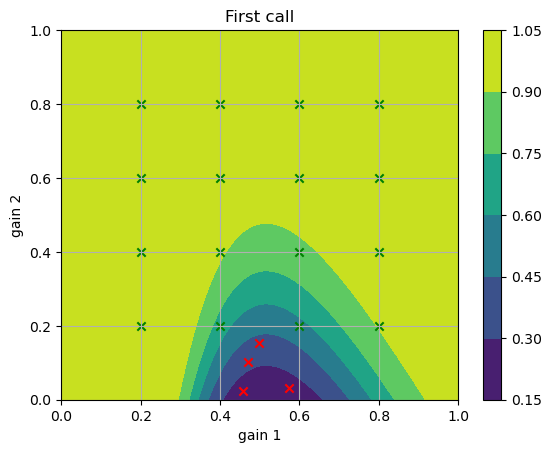

In [570]:
using StatsFuns: normcdf
params = randn(length(params))
params = calculate_parameters(params, flow_model, data_x, data_y)
inferred_model = compile(flow_model, params)
classification_map = map((x) -> normcdf(dot([1,1],x)), map((x) -> forward(inferred_model, [x...]), collect(Iterators.product(0:0.01:1, 0:0.01:1))))
fig, ax = plt.subplots(ncols = 1)
im = ax.contourf(repeat(0:0.01:1, 1, 101), repeat(0:0.01:1, 1, 101)', classification_map)
ax.scatter(hcat(data_x...)[1,findall(x->x==1.0, data_y)], hcat(data_x...)[2,findall(x->x==1.0, data_y)], c="green", marker="x")
ax.scatter(hcat(data_x...)[1,findall(x->x==0.0, data_y)], hcat(data_x...)[2,findall(x->x==0.0, data_y)], c="red", marker="x")
plt.colorbar(im, ax=ax)
ax.grid()
ax.set_xlabel("gain 1"), ax.set_ylabel("gain 2")
ax.set_title("First call");

# Fifth call

In [571]:
optimum = calculate_input(params, flow_model)

Fminbox
-------
Initial mu = 7.96169e-5

Fminbox iteration 1
-------------------
Calling inner optimizer with mu = 7.96169e-5

(numbers below include barrier contribution)
Iter     Function value   Gradient norm 
     0     3.266319e+00     5.958554e-01
 * time: 0.0
     1     3.263811e+00     5.219124e-01
 * time: 0.006999969482421875
     2     3.249049e+00     6.742205e-02
 * time: 0.013000011444091797
     3     3.248696e+00     5.326625e-02
 * time: 0.018000125885009766
     4     3.248168e+00     4.822127e-02
 * time: 0.026000022888183594
     5     3.247982e+00     6.186816e-02
 * time: 0.03299999237060547
     6     3.247830e+00     4.439184e-03
 * time: 0.046000003814697266
     7     3.247825e+00     9.804001e-04
 * time: 0.05299997329711914
     8     3.247825e+00     1.219788e-06
 * time: 0.06100010871887207
     9     3.247825e+00     3.056752e-08
 * time: 0.06599998474121094
    10     3.247825e+00     9.332314e-14
 * time: 0.0710000991821289

Exiting inner optimizer with

2-element Array{Float64,1}:
 0.521610765197772
 0.21463096019852268

In [572]:
data_y = [data_y..., generate_user_response(optimum; μ=[0.5, 0.5], a=1, b=1, c=25, d=-0.4)]
data_x = [data_x..., optimum]

21-element Array{Array{Float64,1},1}:
 [0.2, 0.2]
 [0.4, 0.2]
 [0.6, 0.2]
 [0.8, 0.2]
 [0.2, 0.4]
 [0.4, 0.4]
 [0.6, 0.4]
 [0.8, 0.4]
 [0.2, 0.6]
 [0.4, 0.6]
 [0.6, 0.6]
 [0.8, 0.6]
 [0.2, 0.8]
 [0.4, 0.8]
 [0.6, 0.8]
 [0.8, 0.8]
 [0.4578723807777454, 0.02259223171196023]
 [0.4704493734912905, 0.10187472756470707]
 [0.49682550225670935, 0.15217524598949747]
 [0.5729054632263153, 0.0313758383076371]
 [0.521610765197772, 0.21463096019852268]

In [573]:
data_y

21-element Array{Float64,1}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0

Iter     Function value   Gradient norm 
     0     4.540362e+01     6.286588e+01
 * time: 0.0
     1     3.644212e+01     1.588259e+01
 * time: 0.029000043869018555
     2     1.186289e+01     6.369800e+00
 * time: 0.5929999351501465
     3     1.122665e+01     1.238839e+00
 * time: 0.6080000400543213
     4     1.116851e+01     8.866279e-01
 * time: 0.630000114440918
     5     1.097052e+01     1.572413e+00
 * time: 0.6460001468658447
     6     1.095447e+01     3.498664e-01
 * time: 0.6760001182556152
     7     1.095359e+01     8.137313e-02
 * time: 0.6970000267028809
     8     1.095310e+01     9.748282e-02
 * time: 0.7230000495910645
     9     1.068068e+01     1.841384e+00
 * time: 0.8429999351501465
    10     1.067746e+01     1.923822e+00
 * time: 0.8589999675750732
    11     1.054891e+01     2.329916e+00
 * time: 0.876000165939331
    12     1.036919e+01     3.072833e+00
 * time: 0.9049999713897705
    13     1.004678e+01     2.493289e+00
 * time: 0.9210000038146973
    14  

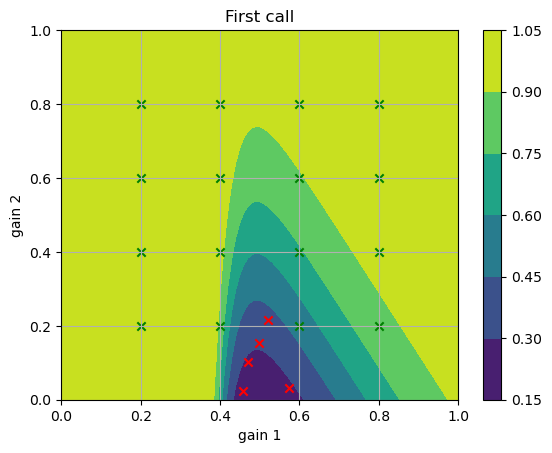

In [574]:
using StatsFuns: normcdf
params = randn(length(params))
params = calculate_parameters(params, flow_model, data_x, data_y)
inferred_model = compile(flow_model, params)
classification_map = map((x) -> normcdf(dot([1,1],x)), map((x) -> forward(inferred_model, [x...]), collect(Iterators.product(0:0.01:1, 0:0.01:1))))
fig, ax = plt.subplots(ncols = 1)
im = ax.contourf(repeat(0:0.01:1, 1, 101), repeat(0:0.01:1, 1, 101)', classification_map)
ax.scatter(hcat(data_x...)[1,findall(x->x==1.0, data_y)], hcat(data_x...)[2,findall(x->x==1.0, data_y)], c="green", marker="x")
ax.scatter(hcat(data_x...)[1,findall(x->x==0.0, data_y)], hcat(data_x...)[2,findall(x->x==0.0, data_y)], c="red", marker="x")
plt.colorbar(im, ax=ax)
ax.grid()
ax.set_xlabel("gain 1"), ax.set_ylabel("gain 2")
ax.set_title("First call");

# Sixth call

In [575]:
optimum = calculate_input(params, flow_model)

Fminbox
-------
Initial mu = 0.000546523

Fminbox iteration 1
-------------------
Calling inner optimizer with mu = 0.000546523

(numbers below include barrier contribution)
Iter     Function value   Gradient norm 
     0     3.643613e+00     2.456018e+00
 * time: 0.0
     1     3.510857e+00     4.367968e+00
 * time: 0.0070002079010009766
     2     3.235501e+00     6.007720e-02
 * time: 0.014000177383422852
     3     3.235239e+00     9.666149e-02
 * time: 0.021000146865844727
     4     3.234715e+00     3.485367e-02
 * time: 0.031000137329101562
     5     3.234571e+00     1.073552e-02
 * time: 0.03800010681152344
     6     3.234562e+00     1.457109e-03
 * time: 0.043000221252441406
     7     3.234562e+00     2.893624e-05
 * time: 0.05000019073486328
     8     3.234562e+00     1.554027e-07
 * time: 0.057000160217285156
     9     3.234562e+00     5.261158e-12
 * time: 0.06300020217895508

Exiting inner optimizer with x = [0.49319076781146814, 0.32704245724106773]
Current distance 

2-element Array{Float64,1}:
 0.49319052420367177
 0.3269043739178375

In [576]:
data_y = [data_y..., generate_user_response(optimum; μ=[0.5, 0.5], a=1, b=1, c=25, d=-0.4)]
data_x = [data_x..., optimum]

22-element Array{Array{Float64,1},1}:
 [0.2, 0.2]
 [0.4, 0.2]
 [0.6, 0.2]
 [0.8, 0.2]
 [0.2, 0.4]
 [0.4, 0.4]
 [0.6, 0.4]
 [0.8, 0.4]
 [0.2, 0.6]
 [0.4, 0.6]
 [0.6, 0.6]
 [0.8, 0.6]
 [0.2, 0.8]
 [0.4, 0.8]
 [0.6, 0.8]
 [0.8, 0.8]
 [0.4578723807777454, 0.02259223171196023]
 [0.4704493734912905, 0.10187472756470707]
 [0.49682550225670935, 0.15217524598949747]
 [0.5729054632263153, 0.0313758383076371]
 [0.521610765197772, 0.21463096019852268]
 [0.49319052420367177, 0.3269043739178375]

In [577]:
data_y

22-element Array{Float64,1}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

Iter     Function value   Gradient norm 
     0     1.311761e+01     7.669961e+00
 * time: 0.0
     1     1.192815e+01     4.727272e+00
 * time: 0.029999971389770508
     2     1.146306e+01     2.461788e+00
 * time: 0.05299997329711914
     3     1.036564e+01     5.477986e+00
 * time: 0.08599996566772461
     4     9.786945e+00     1.747935e+00
 * time: 0.11100006103515625
     5     9.674232e+00     1.829560e+00
 * time: 0.13300013542175293
     6     8.774528e+00     1.559833e+00
 * time: 0.15700006484985352
     7     8.573229e+00     3.153952e+00
 * time: 0.17400002479553223
     8     7.911489e+00     3.401491e+00
 * time: 0.20099997520446777
     9     7.489724e+00     7.414192e+00
 * time: 0.22699999809265137
    10     6.742336e+00     4.050662e+00
 * time: 0.24399995803833008
    11     5.784354e+00     1.269327e+01
 * time: 0.3250000476837158
    12     4.890592e+00     3.506569e+00
 * time: 0.3619999885559082
    13     4.438048e+00     2.953389e+00
 * time: 0.39100003242492

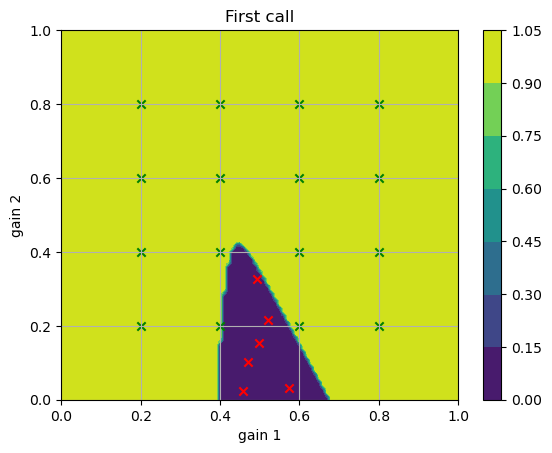

In [579]:
using StatsFuns: normcdf
params = randn(length(params))
params = calculate_parameters(params, flow_model, data_x, data_y)
inferred_model = compile(flow_model, params)
classification_map = map((x) -> normcdf(dot([1,1],x)), map((x) -> forward(inferred_model, [x...]), collect(Iterators.product(0:0.01:1, 0:0.01:1))))
fig, ax = plt.subplots(ncols = 1)
im = ax.contourf(repeat(0:0.01:1, 1, 101), repeat(0:0.01:1, 1, 101)', classification_map)
ax.scatter(hcat(data_x...)[1,findall(x->x==1.0, data_y)], hcat(data_x...)[2,findall(x->x==1.0, data_y)], c="green", marker="x")
ax.scatter(hcat(data_x...)[1,findall(x->x==0.0, data_y)], hcat(data_x...)[2,findall(x->x==0.0, data_y)], c="red", marker="x")
plt.colorbar(im, ax=ax)
ax.grid()
ax.set_xlabel("gain 1"), ax.set_ylabel("gain 2")
ax.set_title("First call");

# Seventh call

In [580]:
optimum = calculate_input(params, flow_model)

Fminbox
-------
Initial mu = 0.0613084

Fminbox iteration 1
-------------------
Calling inner optimizer with mu = 0.0613084

(numbers below include barrier contribution)
Iter     Function value   Gradient norm 
     0     1.061559e+02     4.934809e+02
 * time: 0.0
     1     4.816779e+01     3.367136e+01
 * time: 0.005000114440917969
     2     3.465535e+00     1.121153e+01
 * time: 0.021000146865844727
     3     3.465072e+00     1.185241e+00
 * time: 0.026999950408935547
     4     3.417544e+00     4.629847e+00
 * time: 0.03699994087219238
     5     3.415975e+00     9.734208e+00
 * time: 0.04400014877319336
     6     3.412809e+00     2.101344e+01
 * time: 0.059999942779541016
     7     3.410927e+00     2.687065e+01
 * time: 0.06500005722045898
     8     3.404686e+00     1.805331e+01
 * time: 0.07299995422363281
     9     3.403313e+00     8.127907e+00
 * time: 0.0820000171661377
    10     3.402908e+00     3.694194e+00
 * time: 0.08899998664855957
    11     3.402616e+00     1.55

2-element Array{Float64,1}:
 0.45284157034083333
 0.42096457345591487

In [581]:
data_y = [data_y..., generate_user_response(optimum; μ=[0.5, 0.5], a=1, b=1, c=25, d=-0.4)]
data_x = [data_x..., optimum]

23-element Array{Array{Float64,1},1}:
 [0.2, 0.2]
 [0.4, 0.2]
 [0.6, 0.2]
 [0.8, 0.2]
 [0.2, 0.4]
 [0.4, 0.4]
 [0.6, 0.4]
 [0.8, 0.4]
 [0.2, 0.6]
 [0.4, 0.6]
 [0.6, 0.6]
 [0.8, 0.6]
 [0.2, 0.8]
 [0.4, 0.8]
 [0.6, 0.8]
 [0.8, 0.8]
 [0.4578723807777454, 0.02259223171196023]
 [0.4704493734912905, 0.10187472756470707]
 [0.49682550225670935, 0.15217524598949747]
 [0.5729054632263153, 0.0313758383076371]
 [0.521610765197772, 0.21463096019852268]
 [0.49319052420367177, 0.3269043739178375]
 [0.45284157034083333, 0.42096457345591487]

In [582]:
data_y

23-element Array{Float64,1}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 1.0

Iter     Function value   Gradient norm 
     0     3.099333e+01     2.064206e+01
 * time: 0.0
     1     1.210536e+01     2.388272e+00
 * time: 0.042999982833862305
     2     1.188132e+01     1.226336e+00
 * time: 0.06999993324279785
     3     1.103707e+01     3.450728e+00
 * time: 0.12299990653991699
     4     1.090402e+01     3.876067e+00
 * time: 0.1419999599456787
     5     1.039824e+01     4.529764e+00
 * time: 0.16700005531311035
     6     9.859660e+00     1.924674e+00
 * time: 0.19499993324279785
     7     9.758353e+00     6.463160e-01
 * time: 0.22499990463256836
     8     9.732923e+00     7.572975e-01
 * time: 0.24300003051757812
     9     9.682606e+00     1.448742e+00
 * time: 0.27300000190734863
    10     8.754449e+00     1.592010e+00
 * time: 0.31399989128112793
    11     8.635663e+00     1.195916e+00
 * time: 0.33500003814697266
    12     8.543034e+00     2.215452e+00
 * time: 0.3640000820159912
    13     6.831996e+00     3.724509e+00
 * time: 0.45899987220764

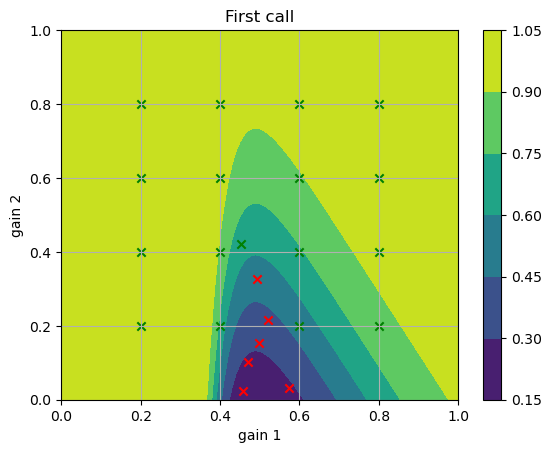

In [583]:
using StatsFuns: normcdf
params = randn(length(params))
params = calculate_parameters(params, flow_model, data_x, data_y)
inferred_model = compile(flow_model, params)
classification_map = map((x) -> normcdf(dot([1,1],x)), map((x) -> forward(inferred_model, [x...]), collect(Iterators.product(0:0.01:1, 0:0.01:1))))
fig, ax = plt.subplots(ncols = 1)
im = ax.contourf(repeat(0:0.01:1, 1, 101), repeat(0:0.01:1, 1, 101)', classification_map)
ax.scatter(hcat(data_x...)[1,findall(x->x==1.0, data_y)], hcat(data_x...)[2,findall(x->x==1.0, data_y)], c="green", marker="x")
ax.scatter(hcat(data_x...)[1,findall(x->x==0.0, data_y)], hcat(data_x...)[2,findall(x->x==0.0, data_y)], c="red", marker="x")
plt.colorbar(im, ax=ax)
ax.grid()
ax.set_xlabel("gain 1"), ax.set_ylabel("gain 2")
ax.set_title("First call");